# Autoencoder and U-Net for MNIST data
---

### Libraries

In [1]:
# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from pytorch_msssim import ssim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Torchvision to download the MNIST data
from torchvision import datasets, transforms

# Skimage
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Others
import os
import random
import warnings
warnings.simplefilter("ignore")

### Functions to get MNIST data and to blur the data

In [2]:
def get_mnist_data(download=True, root='./data'):
    
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    dataset = datasets.MNIST(root=root, train=True, download=download, transform=transform)

    train_set, val_set = random_split(dataset, [50000, 10000])

    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
    val_loader  = DataLoader(val_set, batch_size=128, shuffle=False)
    
    return train_loader, val_loader

class Blur:
    def __init__(self, kernel_size=5, sigma=2.0):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def _create_gaussian_kernel(self, size, sigma):
        coords = torch.arange(size).float() - size // 2
        g = torch.exp(-(coords**2) / (2 * sigma**2))
        g = g / g.sum()
        kernel2d = torch.outer(g, g)
        return kernel2d.view(1, 1, size, size)

    def __call__(self, x, sigma=None):
        sigma = sigma if sigma is not None else self.sigma
        kernel = self._create_gaussian_kernel(self.kernel_size, sigma).to(x.device)
        return F.conv2d(x, kernel, padding=self.kernel_size // 2)

### Available models

In [3]:
#------------------------------------------------------------------------------------------
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
#------------------------------------------------------------------------------------------    
class deepConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2, padding=1, output_padding=1),   
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1, output_padding=0),   
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
#------------------------------------------------------------------------------------------   
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        up1 = self.up1(bottleneck)
        dec1 = self.dec1(torch.cat([up1, enc2], dim=1))
        up2 = self.up2(dec1)
        dec2 = self.dec2(torch.cat([up2, enc1], dim=1))
        return torch.sigmoid(dec2)
#------------------------------------------------------------------------------------------    

### Trainining functions

In [4]:
def train_one_epoch(model, train_loader, blur, criterion_mse, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, _ in train_loader:
        images = images.to(device)

        sigma = random.uniform(0.3, 2.0)
        degraded = blur(images, sigma=sigma)

        outputs = model(degraded)

        loss_mse = nn.functional.mse_loss(outputs, images)
        loss_ssim = 1 - ssim(outputs, images, data_range=1.0, size_average=True)
        loss = 0.7 * loss_mse + 0.3 * loss_ssim

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def train_model(model, train_loader, blur, num_epochs, device):
    criterion_mse = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        avg_loss = train_one_epoch(model, train_loader, blur, criterion_mse, optimizer, device)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


def get_model_filename(model_name, kernel_size, sigma, num_epochs):
    return f"{model_name}_kernel{kernel_size}_sigma{sigma}_epochs{num_epochs}.pth"

### Metrics 

In [5]:
def compute_metrics(img_true, img_pred):
    psnr = peak_signal_noise_ratio(img_true, img_pred, data_range=1.0)
    ssim_val = structural_similarity(img_true, img_pred, data_range=1.0, channel_axis=False)

    return psnr, ssim_val

### Getting data

In [6]:
download = False         # When running for the first time, set it to True to download the data
train_loader, val_loader = get_mnist_data(download=download)

### Training or loading models

In [7]:
#------------------------------------------------------------------------------------------
# Input parameters
#------------------------------------------------------------------------------------------
KERNEL_SIZE   = 7
INITIAL_SIGMA = 5
NUM_EPOCHS    = 5
model_dict    = {"ConvAutoencoder": ConvAutoencoder,
                 "deepConvAutoencoder": deepConvAutoencoder,
                 "UNet": UNet}
#------------------------------------------------------------------------------------------



#------------------------------------------------------------------------------------------
# Loop
#------------------------------------------------------------------------------------------
for model_name, model_class in model_dict.items():
    filename = get_model_filename(model_name, KERNEL_SIZE, INITIAL_SIGMA, NUM_EPOCHS)

    if os.path.exists(filename):
        print(f"Model: {filename} is already available.")
    else:
        print(f"\nTraining model: {model_name}")
        model = model_class().to(device)
        blur = Blur(kernel_size=KERNEL_SIZE, sigma=INITIAL_SIGMA)

        train_model(model, train_loader, blur, NUM_EPOCHS, device)

        torch.save(model.state_dict(), filename)
        print(f"Model saved: {filename}")


Model: ConvAutoencoder_kernel7_sigma5_epochs5.pth is already available.
Model: deepConvAutoencoder_kernel7_sigma5_epochs5.pth is already available.
Model: UNet_kernel7_sigma5_epochs5.pth is already available.


### Plot

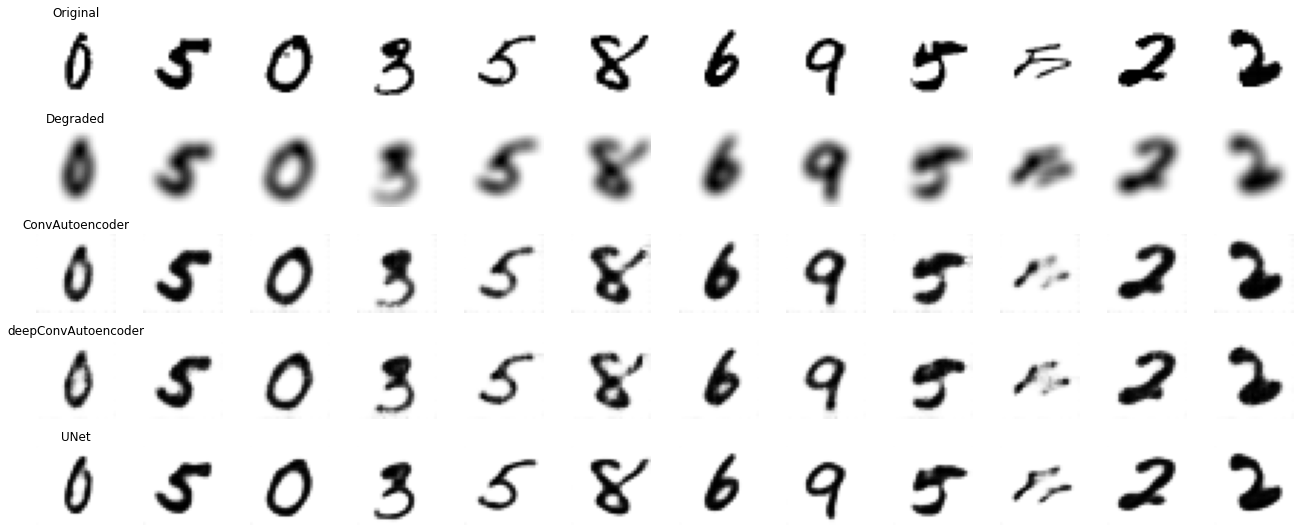

ConvAutoencoder      PSNR: 19.85, SSIM: 0.8650
deepConvAutoencoder  PSNR: 20.27, SSIM: 0.8879
UNet                 PSNR: 23.60, SSIM: 0.9461


In [14]:
#------------------------------------------------------------------------------------------
# Input parameters
#------------------------------------------------------------------------------------------
N_TEST      = 12
SIGMA_EVAL  = 2

#------------------------------------------------------------------------------------------
# Loading validation data
#------------------------------------------------------------------------------------------
images, _ = next(iter(val_loader))
images    = images.to(device)
blur      = Blur(kernel_size=KERNEL_SIZE, sigma=SIGMA_EVAL)
degraded  = blur(images, sigma=SIGMA_EVAL)

#------------------------------------------------------------------------------------------
# Evaluating models
#------------------------------------------------------------------------------------------
outputs_by_model = {}
metrics_by_model = {}
with torch.no_grad():
    for model_name, model_class in model_dict.items():
        filename = f"{model_name}_kernel{KERNEL_SIZE}_sigma5_epochs{NUM_EPOCHS}.pth"
        if not os.path.exists(filename):
            print(f"❌ Model not found: {filename}")
            continue

        model = model_class().to(device)
        model.load_state_dict(torch.load(filename, map_location=device))
        model.eval()

        outputs = model(degraded)
        outputs_by_model[model_name] = outputs

        # Computing metrics
        psnr_total, ssim_total = 0.0, 0.0
        for i in range(N_TEST):
            orig = images[i, 0].cpu().numpy()
            rec = outputs[i, 0].cpu().numpy()
            psnr_i, ssim_i = compute_metrics(orig, rec)
            psnr_total += psnr_i
            ssim_total += ssim_i
        metrics_by_model[model_name] = {
            "psnr": psnr_total / N_TEST,
            "ssim": ssim_total / N_TEST
        }

#------------------------------------------------------------------------------------------
# Visualization
#------------------------------------------------------------------------------------------
n_models = len(outputs_by_model)
fig, axes = plt.subplots(2 + n_models, N_TEST, figsize=(1.5 * N_TEST, 1.5 * (2 + n_models)))

for i in range(N_TEST):
    axes[0, i].imshow(images[i, 0].cpu(), cmap='gray_r')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Original")

    axes[1, i].imshow(degraded[i, 0].cpu(), cmap='gray_r')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Degraded")

    for j, (model_name, output) in enumerate(outputs_by_model.items()):
        axes[2 + j, i].imshow(output[i, 0].cpu(), cmap='gray_r')
        axes[2 + j, i].axis('off')
        if i == 0:
            axes[2 + j, i].set_title(model_name)

plt.tight_layout()
plt.show()

# ----------------------------
# Show metrics
# ----------------------------
for model_name, metrics in metrics_by_model.items():
    print(f"{model_name:20s} PSNR: {metrics['psnr']:.2f}, SSIM: {metrics['ssim']:.4f}")
